In [1]:
import pandas as pd
import lightgbm as lgb
import cgmquantify as cgm
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import seaborn as sns

# Getting all the Glycemic Data for the Samples

In [2]:
# all the sample numbers from 001 to 016
class DataProcessor:
    # constructor
    def __init__(self):
        self.dexcomFormat = "Dexcom_{0}.csv"
        self.accFormat = "ACC_{0}.csv"
        self.foodLogFormat = "Food_Log_{0}.csv"
        self.ibiFormat = "IBI_{0}.csv"
        self.bvpFormat = "BVP_{0}.csv"
        self.edaFormat = "EDA_{0}.csv"
        self.hrFormat = "HR_{0}.csv"
        self.tempFormat = "TEMP_{0}.csv"
      
    # function: creates a dictionary of all of the samples and the desired data
    # input: samples (list of samples), fileType(what type of file we are looking for (lower case))
    # output: dictionary with sample key and numpy array of values
    def loadData(self, samples, fileType):
        data = {}
        if fileType == "dexcom":
            for sample in samples:
                df = pd.read_csv(sample + "/" + self.dexcomFormat.format(sample))
                lst = pd.to_numeric(df['Glucose Value (mg/dL)']).to_numpy()
                lst = lst[~np.isnan(lst)]
                data[sample] = lst
        else:
            for sample in samples:
                data[sample] = np.array([])
        return data
    
    def persComp(self, value, persHigh, persLow):
        if value > persHigh:
            return "PersHigh"
        elif value < persLow:
            return "PersLow"
        return "PersNorm"
    
    # function: creates a dictionary with sample key and array with tuple of value and Pers Value ("PersNorm", "PersHigh", "PersLow")
    # input: data (Glucose Data), swData (Sliding Window Data)
    # output: dictionary of the persDict
    def persValue(self, data, swData):
        persDict = {}
        for key in data.keys():
            persDict[key] = [(data[key][i], self.persComp(data[key][i], swData[key][i][0] + swData[key][i][1], swData[key][i][0] - swData[key][i][1])) for i in range(len(data[key]))]
        return persDict

In [3]:
# get sliding window mean and standard deviation
class SlidingWindow:
    # constructor
    def __init__(self):
        pass
    
    # function: sliding window until a window of that size forms and then keep sweeping
    # input: array, windowSize
    # output: np.array that has the mean and std formatted as: [(mean1, std1), (mean2, std2), ...]
    def slidingWindowView(self, array, windowSize):
        tot = []
        window = 0
        arr = []
        index = 0
        while index < len(array):
            # if the window size is less, increase the size, add tot/window to arr
            if (window < windowSize):
                window += 1
                tot.append(array[index])
                index += 1
            else:
                tot.append(array[index])
                tot.pop(0)
                index += 1
            arr.append((np.mean(tot), np.std(tot)))
        return np.array(arr)
    
    def meanStd(self, array, windowSize):
        windows = sliding_window_view(array, windowSize)
        arr = [(np.mean(window), np.std(window)) for window in windows]
        for i in range(windowSize - 1):
            arr.append(arr[-1])
        return arr

In [4]:
dataProcessor = DataProcessor()
slidingWindow = SlidingWindow()

samples = [str(i).zfill(3) for i in range(1, 17)]

# get data with sample formated {sample: glucoseData, ...}
# NaN data points were dropped
data = {}
data = dataProcessor.loadData(samples, "dexcom")
# 288 points per day
windowSize = 288
# get dictionary of mean and standard deviation for the comparison of each point
swData = {}
for sample in samples:
    swData[sample] = slidingWindow.meanStd(data[sample], windowSize)
# get a dictionary tying value to Pers string ("PersNorm", "PersHigh", "PersLow")
persData = dataProcessor.persValue(data, swData)

Example for ranges for PersNorm, PersHigh, and PersLow.

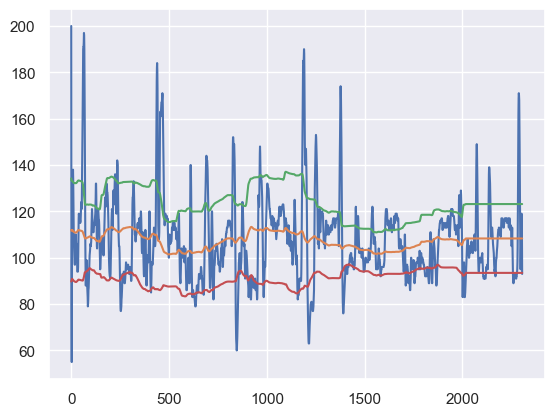

In [5]:
sns.set_theme()
swDataMean = np.array([swData['003'][i][0] for i in range(len(swData['003']))])
swDataStd = np.array([swData['003'][i][1] for i in range(len(swData['003']))])
plt.plot(np.arange(len(data['003'])), data['003'])
plt.plot(np.arange(len(swData['003'])), swDataMean)
plt.plot(np.arange(len(swData['003'])), swDataMean + swDataStd)
plt.plot(np.arange(len(swData['003'])), swDataMean - swDataStd)
plt.show()

# Create DataFrame with Diabetic/Prediabetic/Healthy labels

In [6]:
# Function: return health, prediabetic, diabetic
# Input: Hemoglobin A1C value
# Output: label
def hbA1C(value):
    if value < 5.7:
        return "Normal"
    if value >= 5.7 and value <= 6.4:
        return "Prediabetes"
    else:
        return "Diabetes"

In [7]:
df = pd.read_csv("Demographics.csv")
df["Status"] = df.apply(lambda row: hbA1C(row.HbA1c), axis=1)
df.head(16)

,ID,Gender,HbA1c,Status
0,13,MALE,5.7,Prediabetes
1,1,FEMALE,5.5,Normal
2,3,FEMALE,5.9,Prediabetes
3,4,FEMALE,6.4,Prediabetes
4,5,FEMALE,5.7,Prediabetes
5,2,MALE,5.6,Normal
6,6,FEMALE,5.8,Prediabetes
7,7,FEMALE,5.3,Normal
8,8,FEMALE,5.6,Normal
9,10,FEMALE,6.0,Prediabetes


# Get Data for PersHigh, PersLow, PersNorm

## Get stats of the class sizes of PersHigh, PersLow, PersNorm

In [8]:
persLow = 0
persNorm = 0
persHigh = 0
for key in persData.keys():
    for val, string in persData[key]:
        if string == "PersHigh":
            persHigh += 1
        elif string == "PersLow":
            persLow += 1
        else:
            persNorm += 1
print((persHigh, persNorm, persHigh))

(5669, 26258, 5669)


# Get Data for Each Individual

# Decision Tree (XGBoost and LightGBM)

In [9]:
# get the model set up using the CGM data (confidence booster)
# get analysis on the missingess of the data (figure and summary metrics)
# decision on the imputation
# read on how to impute on certain types of data we are working with

# Transformer

In [10]:
# input: data, length, numSamples
# output: np array of samples and value after
def sample(data, length, numSamples=100):
    ans = []
    for i in range(numSamples):
        start = random.randint(0,len(data)-length-1)
        while np.NaN in data[start: start+length]:
            start = random.randint(0,len(data)-length-1)
        ans.append((data[start: start+length], data[start+length]))
    return np.array(ans)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import random

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [28]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [36]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)
print(type(train_data[0]))

562 batches of size 16
187 batches of size 16
<class 'list'>


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [37]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        print(X)
        print(y_input)
        print(tgt_mask)
        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
        break
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [38]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [2, 0, 1, 0, 1, 0, 1, 0, 1, 3],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
        [2, 0, 1, 0, 1, 0, 1, 0, 1, 3],
        [2, 1, 0, 1, 0, 1, 0, 1, 0, 3],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [2, 1, 0, 1, 0, 1, 0, 1, 0, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
        [2, 1, 0, 1, 0, 1, 0, 1, 0, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3]])
tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 1, 0, 1, 0, 1, 0, 1],
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 0, 1, 0, 1, 0, 1, 0, 1],
        [2

KeyboardInterrupt: 

In [33]:
string = "cp {0}/Dexcom_{0}.csv dexcom"
for i in range(1, 17):
    print(string.format(str(i).zfill(3)))

cp 001/Dexcom_001.csv dexcom
cp 002/Dexcom_002.csv dexcom
cp 003/Dexcom_003.csv dexcom
cp 004/Dexcom_004.csv dexcom
cp 005/Dexcom_005.csv dexcom
cp 006/Dexcom_006.csv dexcom
cp 007/Dexcom_007.csv dexcom
cp 008/Dexcom_008.csv dexcom
cp 009/Dexcom_009.csv dexcom
cp 010/Dexcom_010.csv dexcom
cp 011/Dexcom_011.csv dexcom
cp 012/Dexcom_012.csv dexcom
cp 013/Dexcom_013.csv dexcom
cp 014/Dexcom_014.csv dexcom
cp 015/Dexcom_015.csv dexcom
cp 016/Dexcom_016.csv dexcom
